In [ ]:
!pip install warnings
!pip install tensorflow
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
preprocessed_df = pd.read_csv("/content/clean_data2.csv")

In [ ]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101)

In [ ]:
max_resume_len = 200

In [ ]:

X_train = tokenizer(text=train_df.Resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

In [ ]:
# input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
# attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
input_ids

<KerasTensor: shape=(None, 200) dtype=int32 (created by layer 'input_ids')>

In [ ]:
attention_masks

<KerasTensor: shape=(None, 200) dtype=int32 (created by layer 'attention_mask')>

In [ ]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0]
output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=25,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

In [ ]:
model.layers[2].trainable = True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66962700   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 12),                                                
                                 hidden_states=None                                           

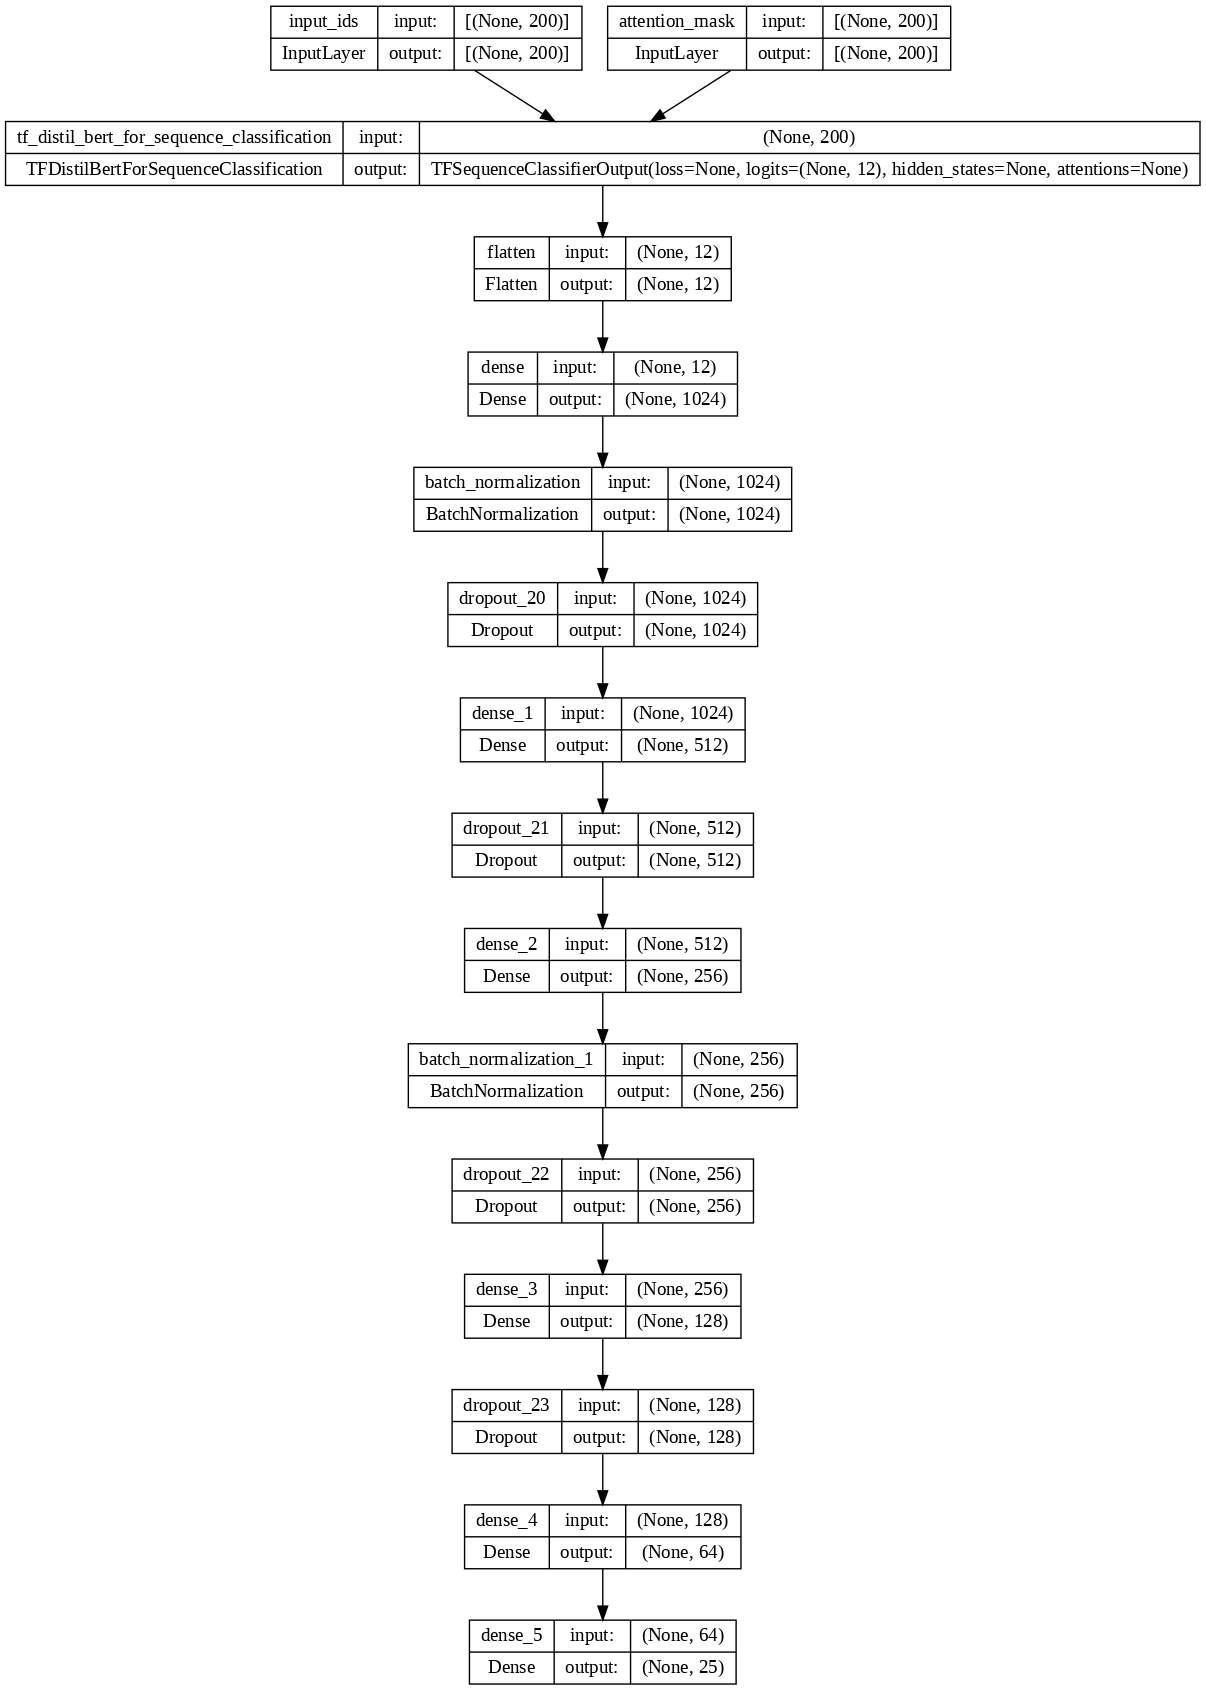

In [ ]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           decay=0.01,
           clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.Category,
             epochs=350,
             batch_size=32,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category))

Epoch 1/350
22/22 [==============================] - ETA: 0s - loss: 3.9048 - balanced_accuracy: 0.0267
Epoch 1: val_balanced_accuracy improved from -inf to 0.03114, saving model to resume_parser.h5
22/22 [==============================] - 43s 991ms/step - loss: 3.9048 - balanced_accuracy: 0.0267 - val_loss: 3.2215 - val_balanced_accuracy: 0.0311
Epoch 2/350
22/22 [==============================] - ETA: 0s - loss: 3.6930 - balanced_accuracy: 0.0416
Epoch 2: val_balanced_accuracy did not improve from 0.03114
22/22 [==============================] - 16s 713ms/step - loss: 3.6930 - balanced_accuracy: 0.0416 - val_loss: 3.2173 - val_balanced_accuracy: 0.0311
Epoch 3/350
22/22 [==============================] - ETA: 0s - loss: 3.6188 - balanced_accuracy: 0.0386
Epoch 3: val_balanced_accuracy improved from 0.03114 to 0.04152, saving model to resume_parser.h5
22/22 [==============================] - 19s 881ms/step - loss: 3.6188 - balanced_accuracy: 0.0386 - val_loss: 3.2231 - val_balanced_ac